In [1]:
import json
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import ToolMessage
# from langchain_teddynote.tools.tavily import TavilySearch
from langchain_community.tools import TavilySearchResults
from IPython.display import Image, display
from dotenv import load_dotenv


load_dotenv()
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
tool = TavilySearchResults(max_results=3, include_raw_content=True) # TavilySearch(max_results=3)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    return {"messages": [answer]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

In [2]:
# TavilySearchResults
tool.invoke("bts")

[{'url': 'https://kprofiles.com/bts-bangtan-boys-members-profile/',
  'content': "\u200eBTS (Bangtan Boys) Members Profile: BTS Ideal Type, BTS Facts BTS (방탄소년단) is a South Korean boy group that consists of 7 members: RM, Jin, Suga, J-Hope, Jimin, V and Jung Kook.They are under Big Hit Music (part of HYBE Labels). BTS debuted on June 13, 2013 with the lead single 'No More Dream' on album '2 Cool 4 Skool'.On June 15, 2022 BigHit Music released an announcement"},
 {'url': 'https://bts.ibighit.com/index.html',
  'content': 'The official website for BTS, the global K-pop superstars. Find their latest news, music, videos, and more.'},
 {'url': 'https://en.wikipedia.org/wiki/BTS',
  'content': 'At the 34th Golden Disc Awards, BTS became the first artists in history to win grand prizes in both the physical and digital categories in a single year.[186] Map of the Soul: Persona was named the second best-selling physical album of 2019 in the US by Nielsen Music behind Taylor Swift\'s Lover and w

In [3]:
class BasicToolNode:
    """Run tools requested in the last AIMessage node"""
    
    def __init__(self, tools:list) -> None:
        self.tools_list = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:
            ########################################################
            # print(tool_call)
            # {
            #     'name': 'tavily_search_results_json', 
            #     'args': {'query': 'Kpop news and updates'}, 
            #     'id': 'call_EX2ImJMJtyFSC3Fwwv5s7uia', 
            #     'type': 'tool_call'
            # }
            ########################################################
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"]
                )
            )
        
        return {"messages": outputs}
            
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [4]:
def route_tools(state: State) -> Literal["tools", "END"]:
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "END"

graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    path_map={
        "tools": "tools",
        "END": END
    }
)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile()


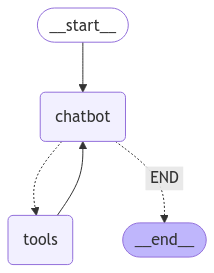

In [5]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
query = "kpop"

for event in graph.stream({"messages": [("user", query)]}):
    for key, value in event.items():
        print(f"STEP: {key}\n{value['messages'][-1]}\n\n")

STEP: chatbot
content='' additional_kwargs={'tool_calls': [{'id': 'call_AUuruD3N8mpKuALPVmSVK3mE', 'function': {'arguments': '{"query":"Kpop news and updates"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 81, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-b6f45352-1bcf-4461-8a09-276d8c454c9b-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kpop news and updates'}, 'id': 'call_AUuruD3N8mpKuALPVmSVK3mE', 'type': 'tool_call'}] usage_metadata={'input_tokens': 81, 'output_tokens': 23, 'total_tokens': 104, 'input_token_details': {'audio': 0, 'cache

In [7]:
result = graph.invoke({"messages": [("user", query)]})
result

{'messages': [HumanMessage(content='kpop', additional_kwargs={}, response_metadata={}, id='6f7cc994-a706-42f9-a223-0edd12db82b0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nCPKyNItTvBQmgmgB2uyHx69', 'function': {'arguments': '{"query":"kpop"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 81, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5330f5af-1688-496f-9c90-fdf846de4b31-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'kpop'}, 'id': 'call_nCPKyNItTvBQmgmgB2uyHx69', 'type': 'tool_call'}], usage_metadata={'inp

In [8]:
from langchain_core.messages import AIMessage, HumanMessage

{
    'messages': [
        HumanMessage(
            content='kpop', 
            additional_kwargs={}, 
            response_metadata={}, 
            id='67e62b8c-15b0-419f-9bbb-92066215319f'
        ),
        AIMessage(
            content='', 
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_M6jnUNaEuGdPoKeCBTHBbX5C', 
                        'function': {
                            'arguments': '{"query":"Kpop news and updates"}', 
                            'name': 'tavily_search_results_json'
                        }, 
                        'type': 'function'
                    }
                ], 
                'refusal': None
            }, 
            response_metadata={
                'token_usage': {'completion_tokens': 23, 'prompt_tokens': 81, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 
                'model_name': 'gpt-4o-mini-2024-07-18', 
                'system_fingerprint': 'fp_72ed7ab54c', 
                'finish_reason': 'tool_calls', 
                'logprobs': None
            }, 
            id='run-53fdf5a5-1808-4954-81b6-d00178009872-0', 
            tool_calls=[
                {
                    'name': 'tavily_search_results_json', 
                    'args': {'query': 'Kpop news and updates'}, 
                    'id': 'call_M6jnUNaEuGdPoKeCBTHBbX5C', 
                    'type': 'tool_call'
                }
            ], 
            usage_metadata={'input_tokens': 81, 'output_tokens': 23, 'total_tokens': 104, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
        ),
        ToolMessage(
            content='''
[
    {
        "url": "https://meaww.com/entertainment/k-pop", 
        "content": "K-POP NEWS Tired Wonyoung has IVE fans worried about her \'too severe\' schedule amid constant Paris trips After the K-pop idol was seen trying to catch her breath during a performance, fans are worried Sep 30, 2022 K-POP NEWS APAN Star Awards 2022: Winners include Park Ji Hu, Yoon Chan Yang while KONNECT artists wow viewers"
    }, 
    {
        "url": "https://www.koreaboo.com/news/", 
        "content": "Latest updates on BTS, EXO, TWICE and every other K-Pop group. Get alerts on breaking K-Pop news and viral buzz on K-Pop idols."
    }, 
    {
        "url": "https://hallyubeat.com/", 
        "content": "K-POP NEWS. PROFILES. LIFESTYLE | FASHION | BEAUTY. Search. TOP NEWS. K-DRAMA & MOVIES. The truth is Unmasked on new Disney+ Hotstar series. Hallyu Unnie-15/01/2025. MUSIC. SM Faces Backlash for Allegedly Sabotaging RED VELVET Again. Administrator-15/01/2025. FEATURES. ADOR Seeks Injunction to Block NEWJEANS From Solo Ad Deals"
    }
]
''', 
            name='tavily_search_results_json', 
            id='f4b04aaf-88f5-4cab-81c3-3445eadac812', 
            tool_call_id='call_M6jnUNaEuGdPoKeCBTHBbX5C'
        ),
        AIMessage(
            content="""
Here are some recent updates and news related to K-pop:

1. **IVE's Wonyoung**: Fans are concerned about Wonyoung's intense schedule after she was seen struggling to catch her breath during a performance. This has raised worries among her supporters regarding her well-being. [Read more here](https://meaww.com/entertainment/k-pop).

2. **K-Pop News Updates**: For the latest updates on popular groups like BTS, EXO, and TWICE, you can check out Korea Boo, which provides alerts on breaking news and viral buzz surrounding K-pop idols. [Visit Korea Boo](https://www.koreaboo.com/news/).

3. **SM Entertainment Controversy**: SM Entertainment is facing backlash for allegedly sabotaging the group Red Velvet. This has sparked discussions among fans and the K-pop community. [More details here](https://hallyubeat.com/).

Feel free to explore these links for more in-depth information!
""", 
            additional_kwargs={'refusal': None}, 
            response_metadata={
                'token_usage': {'completion_tokens': 202, 'prompt_tokens': 390, 'total_tokens': 592, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 
                'model_name': 'gpt-4o-mini-2024-07-18', 
                'system_fingerprint': 'fp_72ed7ab54c', 
                'finish_reason': 'stop', 
                'logprobs': None
            }, 
            id='run-602f6397-9093-4127-891d-2db992f50fa1-0', 
            usage_metadata={'input_tokens': 390, 'output_tokens': 202, 'total_tokens': 592, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
        )
    ]
}

{'messages': [HumanMessage(content='kpop', additional_kwargs={}, response_metadata={}, id='67e62b8c-15b0-419f-9bbb-92066215319f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M6jnUNaEuGdPoKeCBTHBbX5C', 'function': {'arguments': '{"query":"Kpop news and updates"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 81, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-53fdf5a5-1808-4954-81b6-d00178009872-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kpop news and updates'}, 'id': 'call_M6jnUNaEuGdPoKeCBTHBbX5C', 'type': '